# 12. 粒子滤波器

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

# 动机

这个问题让我们思考。我们要追踪移动物体。也许这些物体是战斗机和导弹，或者可能是我们在场地上追踪打板球的人。实际上物体的类型并不重要。我们学到的滤波器中哪一个能够处理这个问题呢？不幸的是，没有一个是理想的。让我们思考一下这个问题的特点。

* **多模态**：我们希望能同时追踪零个、一个或多个物体。

* **遮挡**：一个物体可能隐藏另一个物体，导致一个测量对应多个物体。

* **非线性行为**：飞机会受到风的影响，球会做抛物线运动，人们会相互碰撞。

* **非线性测量**：雷达给我们物体的距离。将其转换为（x，y，z）坐标需要进行平方根运算，这是非线性的。

* **非高斯噪声**：当物体穿过背景时，计算机视觉可能会错误地将背景的一部分误认为物体。

* **连续性**：物体的位置和速度（即状态空间）可以随时间平滑变化。

* **多变量**：我们想要追踪多个属性，比如位置、速度、转向速率等等。

* **未知的过程模型**：我们可能不知道系统的过程模型。

我们学到的滤波器都不能很好地满足所有这些约束条件。

* **离散贝叶斯滤波器**：它具有大多数特征。它是多模态的，可以处理非线性测量，并且可以扩展到处理非线性行为。然而，它是离散和单变量的。

* **卡尔曼滤波器**：卡尔曼滤波器对于高斯噪声的单峰线性系统能够产生最优估计。但对于我们的问题，这些特性都不成立。

* **无迹卡尔曼滤波器**：UKF能够处理非线性、连续、多变量的问题。然而，它不是多模态的，也不能处理遮挡。它可以处理适度非高斯的噪声，但对于非常非高斯的分布或非常非线性的问题效果不佳。

* **扩展卡尔曼滤波器**：EKF与UKF具有相同的优点和局限性，只是它对于强非线性和非高斯噪声更敏感。

# 蒙特卡洛采样

对于UKF章节，我生成了一个类似于这样的图表，来说明非线性系统对高斯分布的影响：

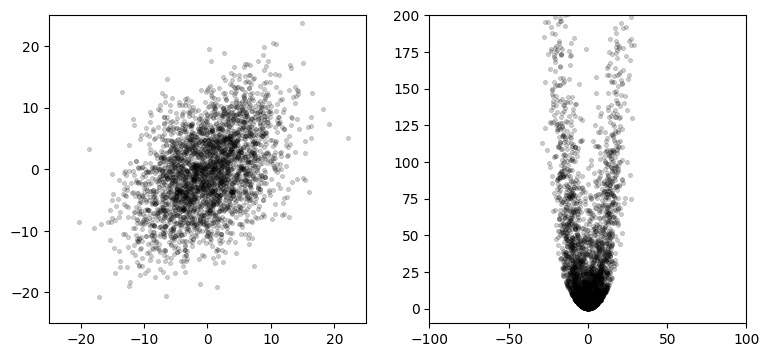

In [3]:
import kf_book.pf_internal as pf_internal
pf_internal.plot_monte_carlo_ukf()

左图显示了基于高斯分布

$$\mu = \begin{bmatrix}0\\0\end{bmatrix},\, \, \, \Sigma = \begin{bmatrix}32&15\\15&40\end{bmatrix}$$

生成的3,000个点。右图显示了这些点通过以下方程组的结果：

$$\begin{aligned}x&=x+y\\
y &= 0.1x^2 + y^2\end{aligned}$$

使用有限数量的随机抽样点来计算结果的方法被称为[*蒙特卡洛*](https://en.wikipedia.org/wiki/Monte_Carlo_method)（MC）方法。其思想很简单。生成足够多的点来获取问题的代表性样本，将这些点输入你所建模的系统，然后计算变换后的点的结果。

总而言之，这就是粒子滤波所做的。我们在整本书中一直使用的贝叶斯滤波算法被应用于成千上万的粒子上，其中每个粒子代表系统的一个*可能*状态。我们通过对粒子的加权统计来从成千上万个粒子中提取估计状态。

# 通用粒子过滤算法

1. **随机生成一堆粒子**
   
   粒子可以具有位置、方向等你需要估计的任何其他状态变量。每个粒子都有一个权重（概率），表示它与系统实际状态匹配的可能性。初始化时，给予每个粒子相同的权重。

2. **预测粒子的下一个状态**

   根据你预测真实系统的行为，移动粒子。

3. **更新**

   根据测量结果更新粒子的权重。与测量结果匹配程度高的粒子将比与测量结果匹配程度较低的粒子获得更高的权重。

4. **重采样**

   丢弃概率极低的粒子，并用概率较高的粒子的副本替换它们。

5. **计算估计值**

   可选地，计算粒子集合的加权均值和协方差，以获得状态估计。

这个简单的算法存在一些实际困难，我们需要克服这些困难，但这是一般的思路。让我们看一个例子。我为UKF和EKF章节中的机器人定位问题编写了一个粒子滤波器。机器人具有转向和速度控制输入。它具有测量可见地标的传感器。传感器和控制机制都存在噪声，并且我们需要追踪机器人的位置。

这里我运行了一个粒子滤波器并绘制了粒子的位置。左图是一次迭代后的结果，右图是经过10次迭代后的结果。红色的 'X' 显示了机器人的实际位置，而大圆圈是计算出的加权均值位置。

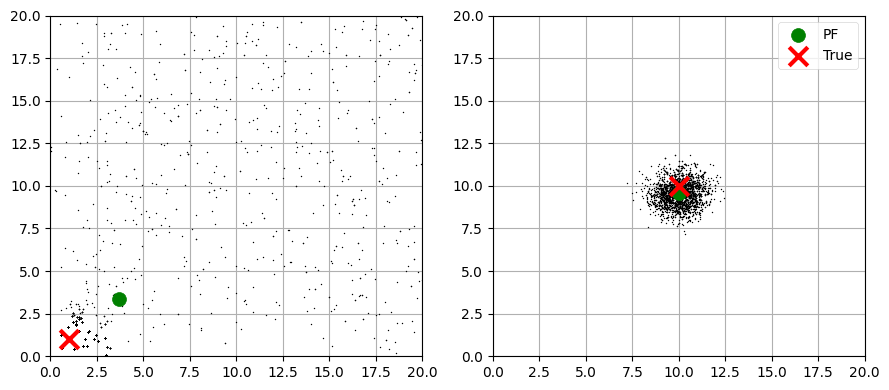

In [4]:
pf_internal.show_two_pf_plots()

如果你在浏览器中观看，这个动画展示了整个序列：

<img src='animations/particle_filter_anim.gif'>

第一轮迭代后，粒子仍然在地图周围随机分散，但你能看到一些已经聚集在机器人附近。计算出的平均值非常接近机器人的位置。这是因为每个粒子根据其与测量值的匹配程度被赋予权重。机器人附近是在（1，1）附近，所以接近（1，1）的粒子权重很高，因为它们与测量值很相近。远离机器人的粒子则与测量值不匹配，因此权重非常低。估计的位置是粒子位置的加权平均值。靠近机器人的粒子对计算的贡献更大，因此估计结果非常准确。

经过几次迭代后，你会发现所有粒子都聚集在机器人周围。这是由于*重采样*步骤。重采样会丢弃不太可能的粒子（权重很低），并用概率更高的粒子替换它们。

我还没有完全解释*为什么*这样会有效，也没有完全解释粒子加权和重采样的算法，但这应该有直观的意义。生成一堆随机粒子，让它们“有点”跟随机器人移动，根据它们与测量值的匹配程度赋予权重，只让可能性大的粒子存活。这看起来应该是有效的，而事实上也确实如此。

# 通过蒙特卡罗的概率分布

假设我们想要计算在区间[0, π]下函数$y= \mathrm{e}^{\sin(x)}$曲线下的面积。这个面积可以通过定积分$\int_0^\pi  \mathrm{e}^{\sin(x)}\, \mathrm{d}x$来计算。作为练习，试着计算答案吧；我会等着你。

如果你明智的话，不会接受那个挑战；$\mathrm{e}^{\sin(x)}$不能被解析地积分。世界上有很多我们无法求解的方程。例如，考虑计算物体的发光度。一个物体会反射部分光线。一些反射光会撞到其他物体并再次照射到原物体上，增加了发光度。这产生了*递归积分*。

然而，使用蒙特卡罗方法计算积分是很简单的。要找到曲线下的面积，创建一个包围框，该框包含所需区间内的曲线。在框内生成随机位置的点，并计算落在曲线下的点与总点数的比例。例如，如果有40%的点落在曲线下，而包围框的面积为1，则曲线下的面积约为0.4。当你趋近于无限的点时，你可以得到任意精度的结果。在实践中，几千个点就可以给出相当准确的结果。

你可以使用这种技术来数值积分任何难度的函数，包括不可积分和不连续的函数。这项技术是由洛斯阿拉莫斯国家实验室的斯坦利·乌拉姆发明的，让他能够进行无法在纸上解决的核反应计算。

我们来通过计算一个圆的面积来求解$\pi$。我们定义一个半径为1的圆，并将其包含在一个正方形内。正方形的边长为2，因此面积为4。我们在框内生成一组均匀分布的随机点，并计算有多少个点落在圆内。圆的面积被计算为框的面积乘以落在圆内的点数与总点数的比值。最后，我们知道$A = \pi r^2$，所以计算出$\pi = A / r^2$。

我们首先创建这些点。

```python
N = 20000
pts = uniform(-1, 1, (N, 2))
```

一个点在圆内，如果它距离圆心的距离小于或等于半径。我们使用`numpy.linalg.norm`计算距离，它计算一个向量的大小。由于向量起始于（0，0），调用norm将计算点到原点的距离。

```python
dist = np.linalg.norm(pts, axis=1)
```

接下来，我们计算哪些距离符合条件。这段代码返回一个布尔数组，如果满足条件`dist <= 1`，则包含`True`：

```python
in_circle = dist <= 1
```

剩下的就是统计圆内的点数，计算π，并绘制结果。我把它们都放在一个单元格中，这样你就可以尝试不同的值来改变`N`，即点的数量。

mean pi(N=20000)= 3.1684
err  pi(N=20000)= -0.0268


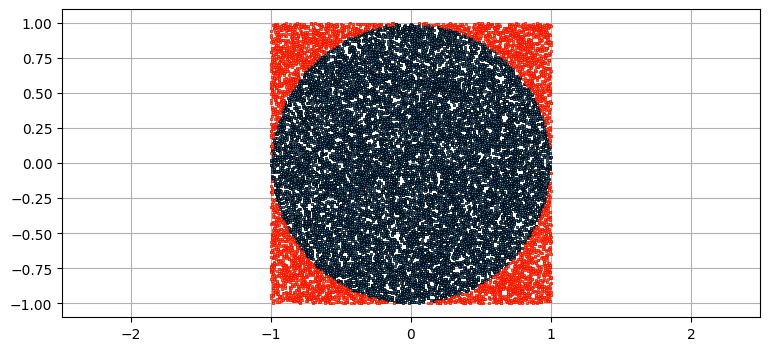

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform 

N = 20000  # number of points
radius = 1.
area = (2*radius)**2

pts = uniform(-1, 1, (N, 2))

# distance from (0,0) 
dist = np.linalg.norm(pts, axis=1)
in_circle = dist <= 1

pts_in_circle = np.count_nonzero(in_circle)
pi = 4 * (pts_in_circle / N)

# plot results
plt.scatter(pts[in_circle,0], pts[in_circle,1], 
            marker=',', edgecolor='k', s=1)
plt.scatter(pts[~in_circle,0], pts[~in_circle,1], 
            marker=',', edgecolor='r', s=1)
plt.axis('equal')

print(f'mean pi(N={N})= {pi:.4f}')
print(f'err  pi(N={N})= {np.pi-pi:.4f}')

这个观点让我们意识到可以使用蒙特卡罗方法计算任何概率分布的概率密度。例如，假设我们有这样一个高斯分布：

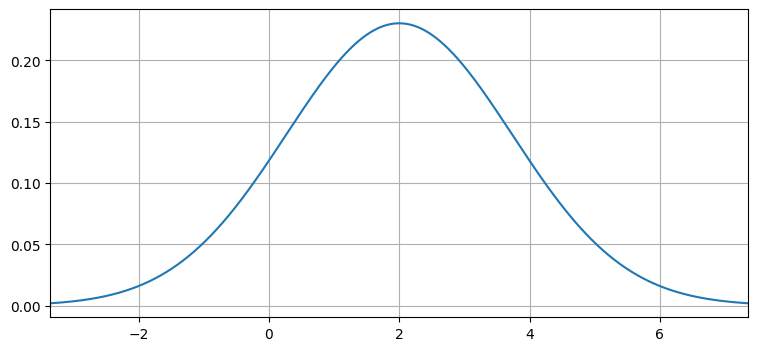

In [6]:
from filterpy.stats import plot_gaussian_pdf
plot_gaussian_pdf(mean=2, variance=3);

概率密度函数（PDF）给出了随机值落在两个值之间的概率。例如，我们可能想知道在上述图表中 x 介于 0 和 2 之间的概率。这是一个连续函数，因此我们需要对其进行积分以找到曲线下的面积，因为该面积等于该值范围内的概率。

$$P[a \le X \le b] = \int_a^b f_X(x) \, dx$$

对于高斯分布来说，计算这个积分很容易。但现实生活并不那么简单。例如，下面的图表显示了一个概率分布。没有办法解析地描述任意曲线，更不用说对其进行积分了。

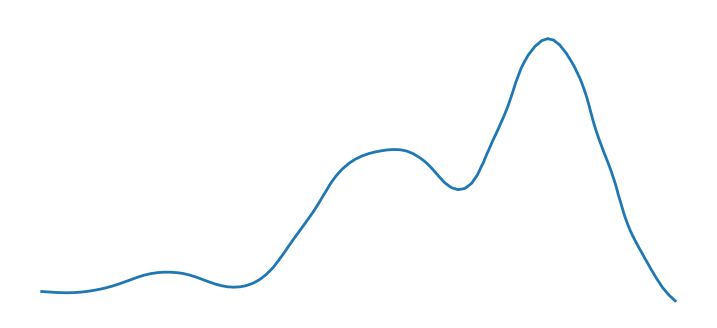

In [7]:
pf_internal.plot_random_pd()

我们可以使用蒙特卡罗方法来计算任何积分。 PDF 是通过积分计算的，因此我们可以使用蒙特卡罗计算该曲线的 PDF。

# 粒子滤波器

这一切都引出了粒子滤波器。想象一下，在城市环境中跟踪一个机器人或一辆车。为了保持连贯性，我将使用前面在扩展卡尔曼滤波（EKF）和无迹卡尔曼滤波（UKF）章节中讨论的机器人定位问题。在这个问题中，我们追踪一个机器人，它有一个传感器，可以测量到已知地标的距离和方位角。

粒子滤波器是一类算法。我介绍的是粒子滤波器的一种具体形式，易于理解，并且与我们在本书中研究过的问题相关。这会使得其中一些步骤看起来有点“神奇”，因为我还没有提供完整的解释。这将在本章后面进行解释。

借鉴前面部分的讨论，我们首先创建了数千个“粒子”。每个粒子都有一个位置，代表着机器人在场景中可能的位置信念，也许还有一个朝向和速度。假设我们对机器人的位置一无所知。我们希望均匀地将这些粒子散布在整个场景中。如果你把所有粒子想象成一个概率分布，粒子较多的地方代表着更高的置信度，而粒子较少的地方则代表着较低的置信度。如果在特定位置附近有一大团粒子，那就意味着我们更确信机器人就在那里。

每个粒子都需要一个权重——理想情况下是代表它表示机器人真实位置的概率。这个概率很少能够计算得到，所以我们只需要它与该概率成比例，这是可计算的。在初始化时，我们没有理由偏好某个粒子而不是另一个，所以我们为$N$个粒子赋予了权重为$1/N$。我们使用$1/N$是为了确保所有概率的总和等于一。

粒子和权重的组合形成了我们问题的*概率分布*。回想一下*离散贝叶斯*章节。在那一章中，我们将走廊上的位置建模为离散且均匀分布。这很类似，只不过这里的粒子是在连续空间中随机分布的，而不是被限制在离散的位置上。在这个问题中，机器人可以在一个任意维度的平面上移动，右下角坐标为(0,0)。

为了追踪我们的机器人，我们需要维护x、y和朝向的状态。我们将在一个形状为`(N, 3)`的数组中存储`N`个粒子。这三列分别包含x、y和朝向。

如果你在被动地追踪某物（没有控制输入），那么你需要在状态中包括速度，并使用该估计值进行预测。更多的维度需要指数级的粒子来形成一个良好的估计，因此我们总是尽量减少状态中的随机变量数量。

这段代码创建了一个区域内的均匀分布和高斯分布的粒子：

In [8]:
from numpy.random import uniform

def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

举个例子：

In [9]:
create_uniform_particles((0,1), (0,1), (0, np.pi*2), 4)

array([[0.772, 0.336, 4.171],
       [0.333, 0.34 , 4.319],
       [0.6  , 0.274, 5.02 ],
       [0.054, 0.022, 5.034]])

# 预测步骤

贝叶斯算法中的预测步骤利用过程模型更新对系统状态的信念。那么，我们如何在粒子滤波中做到这一点呢？每个粒子代表机器人的一个可能位置。假设我们向机器人发送一个命令，让它移动0.1米，并同时转动0.007弧度。我们可以将每个粒子按这个量移动。如果我们这样做，很快就会遇到一个问题。机器人的控制并不完美，所以它不会完全按照命令移动。因此，我们需要给粒子的移动添加噪音，以合理地捕捉到机器人实际的运动。如果你没有对系统中的不确定性进行建模，粒子滤波将无法正确地模拟我们对机器人位置的信念的概率分布。

In [10]:
def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

# 更新步骤

接下来我们会得到一组测量值，每个测量值对应当前可见的一个地标。这些测量值应该如何用来改变我们由粒子模拟的概率分布呢？

回想一下*离散贝叶斯*章节。在那一章中，我们将走廊上的位置建模为离散且均匀分布。我们为每个位置分配了一个概率，我们称之为*先验*。当出现新的测量值时，我们将该位置的当前概率（*先验*）乘以测量值匹配该位置的*似然*：

```python
def update(likelihood, prior):
    posterior = prior * likelihood
    return normalize(posterior)
```

这是一个方程的实现：

$$x = \| \mathcal L \bar x \|$$

这是贝叶斯定理的实现：

$$\begin{aligned}P(x \mid z) &= \frac{P(z \mid x)\, P(x)}{P(z)} \\
 &= \frac{\mathtt{likelihood}\times \mathtt{prior}}{\mathtt{normalization}}\end{aligned}$$

其中 likelihood 代表似然，prior 代表先验，posterior 代表后验。通过将先验与似然相乘，然后进行归一化，我们可以得到后验概率分布。这种更新方式是贝叶斯更新的一种形式，它允许我们利用新的测量值来调整我们对机器人位置的信念。

我们对粒子执行相同的操作。每个粒子都有一个位置和一个权重，用于估计其与测量值匹配的程度。通过对权重进行归一化，使它们的总和为一，我们就可以将它们转换成概率分布。那些距离机器人较近的粒子通常会比距离机器人较远的粒子具有更高的权重。

In [11]:
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

在文献中，这个算法的这一部分被称为*顺序重要性采样*（Sequential Importance Sampling，SIS）。权重的方程被称为*重要密度*（importance density）。我将在接下来的部分给出这些理论基础。现在希望这些能够直观地让你理解。如果我们根据粒子与测量值匹配程度赋予权重，它们很可能是在合并测量值后系统概率分布的良好样本。理论证明了这一点。在贝叶斯定理中，这些权重就是*似然*（likelihood）。不同的问题可能需要以稍微不同的方式来处理这一步骤，但这是一般思路。

# 计算状态估计

在大多数应用中，你可能希望在每次更新后了解估计的状态，但滤波器只是由一组粒子组成。假设我们正在跟踪一个对象（即它是单峰的），我们可以将估计的均值计算为粒子加权值的总和。

$$\displaystyle \mu = \frac{1}{N}\sum_{i=1}^N w^ix^i$$

这里我采用记号 $x^i$ 表示第 $\mathtt{i}$ 个粒子。上标被用来表示，因为我们经常需要使用下标来表示时间步，例如 $\mathtt{k+1}$ 时间步的表达是 $x^i_{k+1}$。

这个函数计算了粒子的均值和方差：

In [12]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

如果我们在一个1x1的正方形区域内创建一个均匀分布的点，并且它们具有相等的权重，我们得到的均值位置会非常接近正方形的中心点 (0.5, 0.5)，而方差会很小。

In [13]:
particles = create_uniform_particles((0,1), (0,1), (0, 5), 1000)
weights = np.array([.25]*1000)
estimate(particles, weights)

(array([0.494, 0.514]), array([0.083, 0.085]))

# 粒子重新抽样

SIS算法存在*退化问题*。它从具有相等权重的均匀分布粒子开始。可能只有少数粒子靠近机器人。随着算法的运行，任何与测量值不匹配的粒子都会获得极低的权重。只有靠近机器人的粒子才会有相当大的权重。我们可能有5000个粒子，但只有其中3个对状态估计有实质性的贡献！我们说滤波器已经*退化*。这个问题通常通过对粒子进行某种形式的*重采样*来解决。

权重非常小的粒子不能有效地描述机器人的概率分布。重采样算法会丢弃概率非常低的粒子，并用具有较高概率的新粒子替换它们。它通过复制具有相对较高概率的粒子来实现。这些副本会在预测步骤中添加的噪音的影响下稍微分散。这样就得到了一组点，其中绝大多数粒子准确地代表了概率分布。

有许多重采样算法。现在让我们看看其中最简单的之一，*简单随机重采样*，也称为*多项式重采样*。它从当前的粒子集中进行了$N$次采样，生成了一个新的粒子集。选择任何给定粒子的概率应该与其权重成比例。

我们可以利用NumPy的`cumsum`函数来实现这一点。`cumsum`计算数组的累积和。也就是说，第一个元素是零和第一个元素的和，第二个元素是零、第一个和第二个元素的和，依此类推。然后，我们生成0.0到1.0范围内的随机数，并进行二分查找，找到最接近该数字的权重：

In [38]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, np.random.rand(N))
    # resample according to indexes
    print(indexes)
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)



我们不会在每个时刻都进行重采样。例如，如果没有收到新的测量值，那么就没有获得任何可以帮助重采样的信息。我们可以通过使用所谓的*有效粒子数*来确定何时进行重采样，它近似地衡量了有意义地贡献到概率分布中的粒子数量。其计算公式为：

$$\hat{N}_\text{eff} = \frac{1}{\sum w^2}$$

我们可以用 Python 来实现这个公式：

In [16]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

如果$\hat{N}_\text{eff}$降到了某个阈值以下，就是重采样的时候了。一个有用的起始点是$N/2$，但这会因问题而异。同时$\hat{N}_\text{eff} = N$ 也是可能的，这意味着粒子集已经合并到一个点（每个粒子具有相等的权重）。这可能在理论上并不完美，但如果发生了这种情况，我会重新创建一个新的粒子分布，希望生成更多样化的粒子。如果这种情况经常发生，你可能需要增加粒子数量，或者调整你的滤波器。我们稍后再详细讨论这个问题。

# SIR 滤波器 - 完整示例

很多知识还在等待探索，但我们已经掌握了足够的知识来实现一个完整的粒子滤波器。我们将实现*采样重要性重采样滤波器*，即SIR。

我需要介绍一个比我之前给出的更复杂的重采样方法。FilterPy提供了几种重采样方法。我稍后会对它们进行描述。它们接受一个权重数组，并返回被选中进行重采样的粒子的索引。我们只需要编写一个函数，根据这些索引执行重采样：

In [32]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

为了实现滤波器，我们需要创建粒子和地标。然后，我们执行一个循环，依次调用`predict`、`update`、重采样，然后使用`estimate`计算新的状态估计。

final position error, variance:
	 [-0.106  0.106] [0.009 0.008]


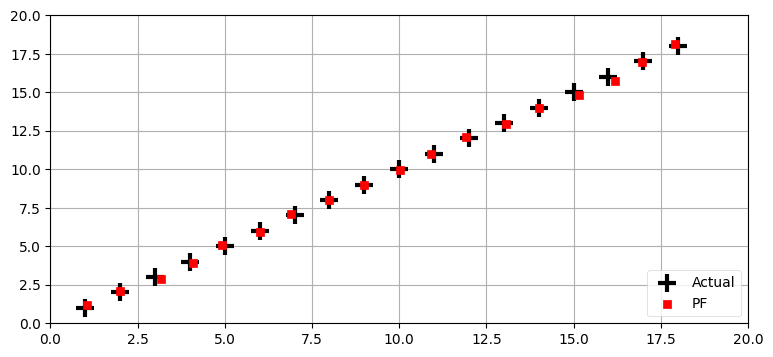

In [39]:
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats

def run_pf1(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    
    plt.figure()
   
    # create particles and weights
    if initial_x is not None:
        particles = create_gaussian_particles(
            mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(particles[:, 0], particles[:, 1], 
                    alpha=alpha, color='g')
    
    xs = []
    robot_pos = np.array([0., 0.])
    for x in range(iters):
        robot_pos += (1, 1)

        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + 
              (randn(NL) * sensor_std_err))

        # move diagonally forward to (x+1, x+1)
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
        
        # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], 
                        color='k', marker=',', s=1)
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',
                         color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    xs = np.array(xs)
    #plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    plt.show()

from numpy.random import seed
seed(2) 
run_pf1(N=5000, plot_particles=False)

这段代码中大部分用于初始化和绘图。粒子滤波器处理的全部内容包括以下代码：

```python
# 向对角线前进到（x+1, x+1）
predict(particles, u=(0.00, 1.414), std=(.2, .05))

 # 合并测量值
update(particles, weights, z=zs, R=sensor_std_err, 
       landmarks=landmarks)
       
# 如果有效粒子数过少，则进行重采样
if neff(weights) < N/2:
    indexes = systematic_resample(weights)
    resample_from_index(particles, weights, indexes)

mu, var = estimate(particles, weights)
```

第一行预测粒子的位置，假设机器人是直线运动的（`u[0] == 0`），在x和y轴上移动1个单位（`u[1]==1.414`）。转向误差的标准差为0.2，距离的标准差为0.05。当这个调用返回时，所有粒子都已向前移动，但权重不再正确，因为它们还没有被更新。

接下来的一行将测量值合并到滤波器中。这不会改变粒子的位置，只会改变权重。如果回忆一下，粒子的权重是根据其匹配传感器误差模型高斯分布的概率计算得到的。粒子与测量距离越远，它代表实际的可能性就越小。

最后两行是检查有效粒子数量（$\hat{N}_\text{eff}$）。如果低于$N/2$，我们执行重采样，以确保粒子形成了实际概率分布的良好表示。

现在让我们来看看所有的粒子是如何绘制的。实时观察这个过程会更有教学意义，但这种格式也能给我们提供有用的信息。我用非常浅的绿色和大圆圈绘制了原始随机点的分布，以帮助将它们与后续迭代中的黑色像素绘制的粒子区分开。由于粒子数量很多，很难看清细节，因此我将迭代次数限制为8次，这样我们可以放大并仔细观察。

final position error, variance:
	 [-0.019 -0.005] [0.005 0.006]


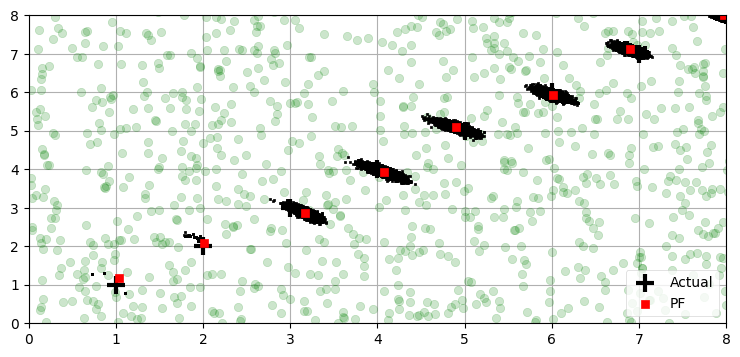

In [40]:
seed(2)
run_pf1(N=5000, iters=8, plot_particles=True, 
        xlim=(0,8), ylim=(0,8))

看起来在前两个机器人位置处只有很少的粒子。但实际上有5000个粒子，但由于重采样的缘故，大多数粒子是彼此的副本。这是因为传感器的高斯分布非常窄。这被称为*样本贫化*，可能导致滤波器发散。我将在下面详细讨论这个问题。现在，看看在x=2时的第二步，我们可以看到粒子有些分散。这种分散是由运动模型的噪声引起的。所有粒子都根据控制输入 `u` 向前投影，但对每个粒子添加的噪声与机器人控制机制中的误差成比例。到了第三步，粒子已经分散得足够多，形成了一个围绕机器人的令人信服的粒子云。

粒子云的形状是一个椭圆。这不是巧合。传感器和机器人控制都被建模为高斯分布，因此系统的概率分布也是高斯分布。粒子滤波器是对概率分布的抽样，所以粒子云应该是一个椭圆。

重要的是要认识到，粒子滤波器算法*不要求*传感器或系统是高斯的或线性的。因为我们用一团粒子来表示概率分布，所以我们可以处理任何概率分布和强非线性问题。概率模型中可能存在不连续和硬限制。

# 传感器误差对过滤器的影响

在滤波器的最初几次迭代中，出现了许多重复的粒子。这是因为传感器的模型是高斯的，并且我们给了它一个很小的标准偏差 $\sigma=0.1$。这一点起初可能有些反直觉。卡尔曼滤波在噪声较小时表现更好，但粒子滤波可能表现更差。

我们可以推理为什么会这样。如果 $\sigma=0.1$，机器人在(1, 1)处，而粒子在(2, 2)处，则该粒子与机器人相距14个标准差。这使得它的概率接近于零。它对均值估计几乎没有贡献，并且在重采样后极不可能幸存下来。如果 $\sigma=1.4$，那么粒子只有 $1\sigma$ 的距离，因此它将对均值估计有所贡献。在重采样过程中，它很可能被复制一次或多次。

这一点非常重要——一个非常精确的传感器可能会导致滤波器性能不佳，因为很少有粒子能够很好地代表概率分布。我们有一些方法可以修复这个问题。首先，我们可以人为地增加传感器噪声的标准偏差，这样粒子滤波器将接受更多点作为与机器人概率分布匹配的点。这并不是最优的，因为其中一些点将与机器人的概率分布匹配度较差。真正的问题是没有生成足够多的点，以便有足够多的点靠近机器人。增加 `N` 通常可以解决这个问题。这个决定并非没有代价，因为增加粒子数量会显著增加计算时间。但让我们看看使用100,000个粒子的结果。

final position error, variance:
	 [-0.17   0.084] [0.005 0.005]


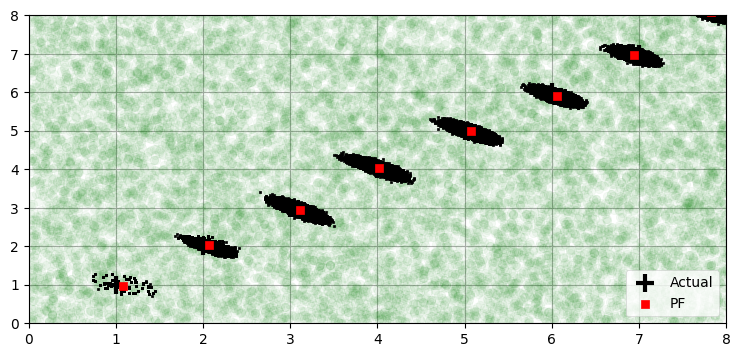

In [41]:
seed(2) 
run_pf1(N=100000, iters=8, plot_particles=True, 
        xlim=(0,8), ylim=(0,8))

在 x=1 处有更多的粒子，而在 x=2 处我们有一个令人信服的粒子云。显然，滤波器的性能更好了，但代价是大量的内存使用和长时间的运行。

另一种方法是在生成初始粒子云时更加智能。假设我们猜测机器人附近是 (0, 0)。这并不完全准确，因为实际的模拟将机器人放在了 (1, 1)，但它是接近的。如果我们在 (0, 0) 附近创建一个正态分布的粒子云，那么粒子与机器人位置匹配的可能性就会大大增加。

`run_pf1()` 函数有一个可选参数 `initial_x`。使用它来指定机器人的初始位置猜测。代码然后使用 `create_gaussian_particles(mean, std, N)` 来创建围绕初始猜测位置正态分布的粒子。我们将在下一节中使用这个参数。

# 样本不足导致滤波器的简并问题

按照现有的滤波器写法，性能并不完美。以下是使用不同的随机种子运行后的性能表现。

final position error, variance:
	 [  0.025 -28.67 ] [34.283 60.008]


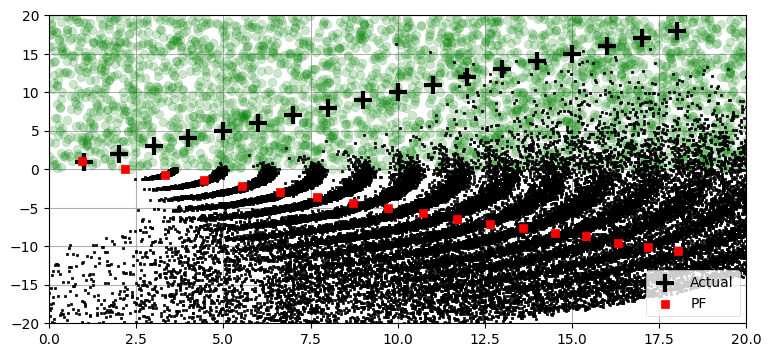

In [44]:
seed(6) 
run_pf1(N=3000, plot_particles=True, ylim=(-20, 20))

在这个例子中，初始的样本点并没有生成任何靠近机器人的点。粒子滤波器在重采样操作时不会创建新的点，因此它最终会复制那些并不能代表概率分布的点。正如之前提到的那样，这被称为*样本贫化*。问题很快就失控了。由于粒子与地形测量不匹配，它们在一个高度非线性、弯曲的分布中散开，粒子滤波器脱离了现实。在机器人附近没有可用的粒子，因此它永远无法收敛。

让我们利用`create_gaussian_particles()`方法尝试生成更多靠近机器人的点。我们可以通过使用`initial_x`参数来指定一个位置来创建这些粒子。

final position error, variance:
	 [ 0.035 -0.077] [0.007 0.009]


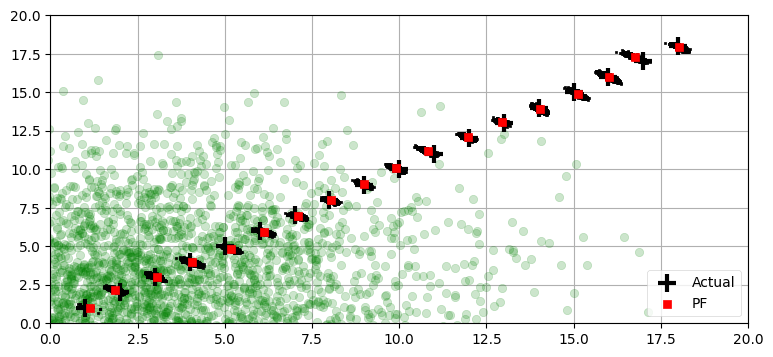

In [45]:
seed(6) 
run_pf1(N=5000, plot_particles=True, initial_x=(1,1, np.pi/4))

这次效果很好。如果你有办法粗略估计初始位置，应该尽量在初始位置附近创建粒子。不要*太*小心——如果你把所有的点都生成在一个位置附近，这些粒子可能就不会分散得足够来捕捉系统中的非线性。这个系统相当线性，所以我们可以用一个较小的方差来分布这些粒子。显然，这取决于你的问题。增加粒子数量总是获得更好样本的好方法，但计算成本可能会让你付出更高的代价。

# 重要性采样

我已经对一个我们现在必须面对的困难进行了化解。有一个概率分布描述了机器人的位置和运动。我们想从那个分布中抽取一些粒子样本，并使用MC方法计算积分。

我们的困难在于，在许多问题中，我们并不知道这个分布。例如，被跟踪的对象可能移动方式与我们状态模型的预测大不相同。我们如何从一个未知的概率分布中抽取样本呢？

统计学中有一个定理叫做[*重要性采样*](https://en.wikipedia.org/wiki/Importance_sampling)。令人惊奇的是，它给了我们一种方法，从不同的已知概率分布中抽取样本，并用这些样本计算未知分布的特性。这是一个奇妙的定理，让我感到欣喜。

这个想法很简单，而且我们已经在使用它。我们从已知的概率分布中抽样，但根据我们感兴趣的分布*给样本加权*。然后我们可以通过计算样本的加权平均值和加权方差来计算均值和方差等性质。

对于机器人定位问题，我们从状态模型预测步骤计算出的概率分布中抽取样本。换句话说，我们推理‘机器人在这里，可能以这个方向和速度移动，因此可能在这里’。然而机器人可能做了完全不同的事情。它可能从悬崖上掉下来，或者被迫击炮击中。在每种情况下，概率分布都不正确。看起来我们陷入了困境，但其实不是，因为我们可以使用重要性采样。我们从那个可能不正确的概率分布中抽取粒子，然后根据粒子与测量值匹配程度对它们进行加权。这种加权是基于真实的概率分布的，因此根据理论，得到的均值、方差等将是正确的！

这怎么可能呢？我给你看数学公式；如果你不打算深入了解机器人定位问题之外的内容，你可以安全地跳过这部分。然而，其他粒子滤波问题需要不同的重要性采样方法，数学知识会有所帮助。此外，文献和网络上的大部分内容都使用数学公式来表达，而不是我比较不精确的“想象……”解释。如果你想理解相关文献，你需要了解以下方程式。

我们有一个概率分布 $\pi(x)$，我们想从中抽取样本。然而，我们不知道 $\pi(x)$ 是什么；相反，我们只知道另一个概率分布 $q(x)$。在机器人定位的情境中，$\pi(x)$ 是机器人的概率分布，但我们不知道它，$q(x)$ 是我们的测量概率分布，我们知道。

具有概率分布 $\pi(x)$ 的函数 $f(x)$ 的期望值为

$$\mathbb{E}\big[f(x)\big] = \int f(x)\pi(x)\, dx$$

我们不知道 $\pi(x)$，所以无法计算这个积分。但我们知道另一个分布 $q(x)$，所以可以将其添加到积分中而不改变值

$$\mathbb{E}\big[f(x)\big] = \int f(x)\pi(x)\frac{q(x)}{q(x)}\, dx$$

现在我们重新排列和分组项

$$\mathbb{E}\big[f(x)\big] = \int f(x)q(x)\, \,  \cdot \,  \frac{\pi(x)}{q(x)}\, dx$$

我们知道 $q(x)$，所以我们可以使用MC积分计算 $\int f(x)q(x)$。这留下了 $\pi(x)/q(x)$。这是一个比例，我们将其定义为*权重*。这给了我们

$$\mathbb{E}\big[f(x)\big] = \sum\limits_{i=1}^N f(x^i)q(x^i)w(x^i)$$

也许这看起来有点抽象。如果我们想计算粒子的均值，我们将计算

$$\mu = \frac{1}{N}\sum\limits_{i=1}^N x^iw^i$$

这就是我之前在章节中给出的方程式。

权重必须与比例 $\pi(x)/q(x)$ 成正比。我们通常不知道精确的值，所以实际上，我们通过将它们除以 $\sum w(x^i)$ 来对权重进行归一化。

当你制定粒子滤波算法时，你将根据你的情况实现这一步骤。对于机器人定位问题，用于 $q(x)$ 的最佳分布是滤波器的 `predict()` 步骤中的粒子分布。让我们再看一下代码：

```python
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        dist = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(dist, R).pdf(z[i])

    weights += 1.e-300      # 避免舍入为零
    weights /=

 sum(weights) # 归一化
```

在这里，我们根据贝叶斯计算计算权重，即 $\| \text{似然度} \times \text{先验}\|$

当然，如果你能够从先验计算出后验概率分布，你应该这样做。如果不能，重要性采样为解决这个问题提供了一种方法。在实践中，计算后验概率是非常困难的。卡尔曼滤波器之所以取得了惊人的成功，是因为它利用了高斯分布的特性找到了解析解。一旦我们放宽了卡尔曼滤波器所需的条件（马尔可夫性质、高斯测量和过程），重要性采样和蒙特卡罗方法就使问题变得可处理了。

# 重采样方法

重采样算法会影响滤波器的性能。例如，假设我们通过随机选择粒子进行重采样。这会导致我们选择许多权重非常低的粒子，最终得到的粒子集合将是问题概率分布的糟糕表示。

对这个主题的研究仍在进行中，但有几种算法在实践中表现良好，适用于各种情况。我们希望算法具有几个特性。它应该更倾向于选择具有更高概率的粒子。它应该选择高概率粒子的代表性群体，以避免样本枯竭。它应该包括足够数量的低概率粒子，以使滤波器有机会检测到强非线性行为。

FilterPy实现了几种流行的算法。FilterPy并不知道你的粒子滤波器是如何实现的，因此它无法生成新的样本。相反，这些算法会创建一个包含被选中粒子索引的 `numpy.array`。你的代码需要执行重采样步骤。例如，我在机器人的代码中使用了以下方法：

In [46]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill(1.0 / len(weights))

# 多项式重采样

多项式重采样是我在开发机器人定位示例时使用的算法。这个想法很简单。计算归一化权重的累积和。这会给你一个从0到1递增的数组。下面是一张图，说明了这个方法是如何分布权重的。颜色是没有意义的，它们只是为了更容易看出这些分割。

cumulative sume is [0.1 0.3 0.4 1. ]


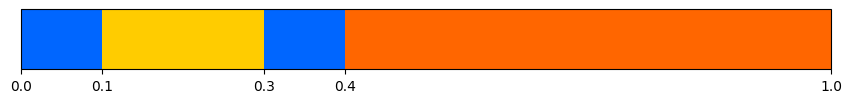

In [47]:
from kf_book.pf_internal import plot_cumsum
print('cumulative sume is', np.cumsum([.1, .2, .1, .6]))
plot_cumsum([.1, .2, .1, .6])

要选择一个权重，我们生成一个在0到1之间均匀选择的随机数，并使用二分查找找到它在累积和数组中的位置。较大的权重占据的空间比较小的权重多，因此被选择的可能性更大。

使用NumPy的[ufunc](http://docs.scipy.org/doc/numpy/reference/ufuncs.html)支持非常容易编写这段代码。Ufuncs将函数应用于数组的每个元素，返回结果数组。`searchsorted`是NumPy的二分查找算法。如果你向它提供一个搜索值的数组，它将返回一个答案的数组：每个搜索值一个答案。

In [48]:
def multinomal_resample(weights):
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.  # avoid round-off errors
    return np.searchsorted(cumulative_sum, random(len(weights)))

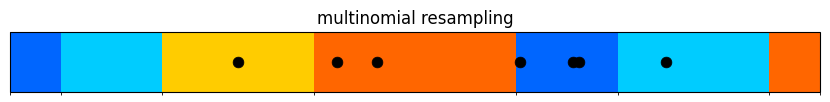

In [49]:
#例子
from kf_book.pf_internal import plot_multinomial_resample
plot_multinomial_resample([.1, .2, .3, .4, .2, .3, .1])

这是一个$O(n \log(n))$的算法。虽然不算糟糕，但是有$O(n)$复杂度的重采样算法在样本均匀性方面具有更好的性质。我展示这个是因为你可以将其他算法理解为对这个算法的变体。有一种更快的多项式重采样实现使用了分布的累积分布函数（CDF）的倒数。如果你感兴趣，可以在互联网上搜索相关信息。

通过以下方式从FilterPy中导入该函数：

```python
from filterpy.monte_carlo import multinomal_resample
```

# 残差重采样

残差重采样提高了多项式重采样的运行速度，并确保对粒子群体的抽样是均匀的。这个方法相当巧妙：将归一化权重乘以*N*，然后每个权重的整数部分用于定义将抽取该粒子的样本数量。例如，如果一个粒子的权重是0.0012，而*N*=3000，那么缩放后的权重是3.6，因此该粒子将被抽取3次样本。这确保了至少选择了所有更高权重的粒子一次。其运行时间为$O(N)$，比多项式重采样更快。

然而，这并不会生成所有*N*个选择。为了选择其余的样本，我们取*残差*：权重减去整数部分，留下数字的小数部分。然后我们使用类似多项式的简单抽样方案，根据残差选择其余的粒子。在上面的例子中，缩放权重是3.6，所以残差将是0.6（3.6 - int(3.6)）。这个残差很大，所以这个粒子可能会再次被抽样。这是合理的，因为残差越大，四舍五入误差越大，因此在整数步骤中该粒子相对地被低估了。

In [52]:
def residual_resample(weights):
    N = len(weights)
    indexes = np.zeros(N, 'i')

    # take int(N*w) copies of each weight
    num_copies = (N*np.asarray(weights)).astype(int)
    k = 0
    for i in range(N):
        for _ in range(num_copies[i]): # make n copies
            indexes[k] = i
            k += 1

    # use multinormial resample on the residual to fill up the rest.
    residual = w - num_copies     # get fractional part
    residual /= sum(residual)     # normalize
    cumulative_sum = np.cumsum(residual)
    cumulative_sum[-1] = 1. # ensures sum is exactly one
    indexes[k:N] = np.searchsorted(cumulative_sum, random(N-k))

    return indexes


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

你可能会尝试用切片来替换内部的for循环，比如 `indexes[k:k + num_copies[i]] = i`，但是非常短的切片相对较慢，而for循环通常运行得更快。

让我们看一个例子：

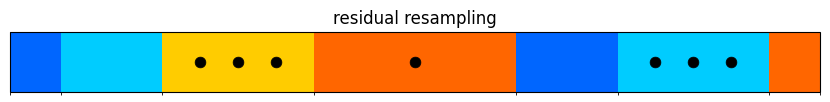

In [51]:
from kf_book.pf_internal import plot_residual_resample
plot_residual_resample([.1, .2, .3, .4, .2, .3, .1])

你可以通过以下方式从FilterPy中导入这个函数：

```python
from filterpy.monte_carlo import residual_resample
```

# 分层重采样

这个方案旨在相对均匀地在粒子之间进行选择。它的原理是将累积和分成$N$个相等的部分，然后从每个部分随机选择一个粒子。这保证了每个样本之间的距离在0到$\frac{2}{N}$之间。

下面的图示说明了这一点。彩色的条形图显示了数组的累积和，黑色的线显示了$N$个相等的划分。粒子，表示为黑色圆圈，在每个划分中随机放置。

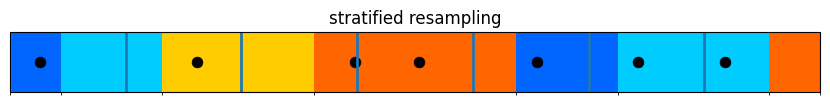

In [53]:
from kf_book.pf_internal import plot_stratified_resample
plot_stratified_resample([.1, .2, .3, .4, .2, .3, .1])

执行分层的代码非常简单明了。

In [54]:
def stratified_resample(weights):
    N = len(weights)
    # make N subdivisions, chose a random position within each one
    positions = (random(N) + range(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

你可以通过以下方式从FilterPy中导入它：

```python
from filterpy.monte_carlo import stratified_resample
```

# 系统重采样

我们要看的最后一个算法是系统重采样。与分层重采样类似，空间被分成$N$个部分。然后我们选择一个随机偏移量用于所有的部分，确保每个样本之间正好相隔$\frac{1}{N}$。它的效果如下。

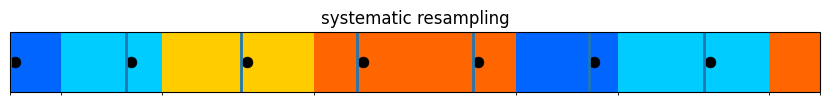

In [55]:
from kf_book.pf_internal import plot_systematic_resample
plot_systematic_resample([.1, .2, .3, .4, .2, .3, .1])

看过前面的例子后，这段代码再简单不过了。

In [72]:
def systematic_resample(weights):
    N = len(weights)

    # make N subdivisions, choose positions 
    # with a consistent random offset
    positions = (np.arange(N) + np.random.rand()) / N
    print(positions)

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    print(cumulative_sum)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

systematic_resample([.1, .2, .3, .4, .2, .3, .1])

[0.075 0.217 0.36  0.503 0.646 0.789 0.932]
[0.1 0.3 0.6 1.  1.2 1.5 1.6]


array([0, 1, 2, 2, 3, 3, 3], dtype=int32)

你可以通过以下方式从FilterPy中导入它：

```python
from filterpy.monte_carlo import systematic_resample
 ```

# 选择重采样算法

让我们同时看一下这四种算法，这样它们就更容易比较了。

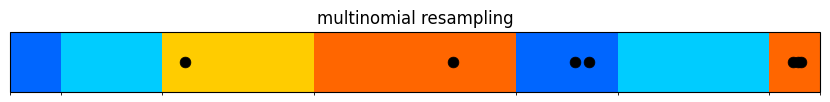

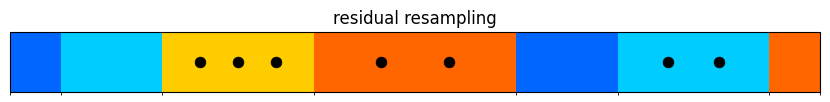

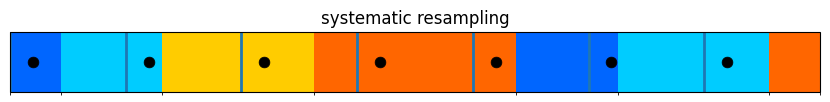

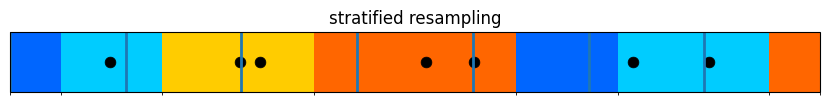

In [58]:
a = [.1, .2, .3, .4, .2, .3, .1]
np.random.seed(4)
plot_multinomial_resample(a)
plot_residual_resample(a)
plot_systematic_resample(a)
plot_stratified_resample(a)

多项式重采样的性能相当糟糕。有一个非常大的权重根本没有被抽到样本。最大的权重只被抽到一次样本，而最小的权重被抽到了两次样本。我阅读过的大多数网络教程都使用多项式重采样，但我不确定为什么。多项式重采样在文献中或实际问题中很少被使用。我建议除非你有很好的理由，否则不要使用它。

残差重采样算法在其目标上表现出色：确保所有最大的权重被多次重新抽样。它并不均匀地分配样本到粒子上——许多相当大的权重根本没有被重新抽样。

系统和分层重采样都表现得非常好。系统抽样在确保我们从粒子空间的所有部分抽样的同时，确保较大的权重被比例地多次重新抽样方面表现出色。分层重采样虽然不像系统重采样那样均匀，但在确保较高权重更多次重新抽样方面稍微更好一些。

关于这些算法的理论性能已经有很多文献，你可以自行阅读。在实践中，我将粒子滤波器应用于难以进行分析的问题上，因此我对特定分析在这些问题上的有效性有些怀疑。在实践中，系统和分层算法在各种问题上表现良好且相似。我建议尝试其中一个，如果有效就坚持使用。如果滤波器的性能至关重要，可以尝试使用两种算法，也许可以查找关于你特定问题的文献，以获得更好的指导。

# 总结

这一章只是触及了一个庞大的话题表面。我的目标不是教授你整个领域，而是向你介绍用于滤波的实用贝叶斯蒙特卡洛技术。

粒子滤波器是*集合*滤波器的一种。卡尔曼滤波器用高斯表示状态。测量值使用贝叶斯定理应用于高斯，预测则使用状态空间方法。这些技术应用于高斯——概率分布。

相比之下，集合技术使用离散的点集和相关的概率来表示概率分布。测量应用于这些点，而不是高斯分布。同样地，系统模型应用于这些点，而不是高斯。然后我们计算所得点集的统计性质。

这些选择有许多权衡。卡尔曼滤波器非常高效，如果线性和高斯噪声的假设成立，则是最优估计器。如果问题是非线性的，我们必须对问题进行线性化处理。如果问题是多模态的（跟踪多个对象），那么卡尔曼滤波器无法表示它。卡尔曼滤波器要求你知道状态模型。如果你不知道系统的行为，性能会很差。

相比之下，粒子滤波器适用于任何任意的非解析概率分布。如果粒子的集合足够大，它们将构成分布的准确近似。即使在严重的非线性情况下，它也能表现出色。重要性采样允许我们计算概率，即使我们不知道潜在的概率分布。蒙特卡洛技术取代了其他滤波器所需的解析积分。

这种强大的能力是有代价的。最明显的代价是滤波器给计算机带来的高计算和内存负担。不太明显的是，它们是很敏感的。你必须小心避免粒子退化和发散。证明滤波器的正确性可能非常困难。如果你正在处理多模态分布，你还需要进一步工作来对粒子进行聚类，以确定多个对象的路径。当对象彼此靠近时，这可能非常困难。

有许多不同类别的粒子滤波器；我只描述了朴素的SIS算法，并随后描述了性能良好的SIR算法。有许多类别的滤波器，在每个类别中有许多示例。描述它们所有需要一本小书。

当你阅读关于粒子滤波器的文献时，你会发现它充斥着积分。我们使用积分在概率分布上执行计算，因此使用积分给作者提供了强大而简洁的符号。你必须认识到，当你将这些方程式转化为代码时，你将用粒子表示分布，积分将被替换为对粒子的求和。如果你牢记本章的核心思想，这些内容就不应该让你感到困扰。

# 参考

[1] *Importance Sampling*, Wikipedia.
https://en.wikipedia.org/wiki/Importance_sampling
